In [24]:
pip install pyspark


In [25]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Breast Cancer Data Analysis") \
    .getOrCreate()

# Define headers based on dataset structure
columns = [
    "recurrence_status", "age", "menopause", "tumor_size", "inv_nodes",
    "node_caps", "deg_malig", "breast", "breast_quad", "irradiat"
]

# Load dataset with headers
file_path = "/content/breast-cancer.data"  # Replace with the actual path
df = spark.read.csv(file_path, header=False, inferSchema=True)
df = df.toDF(*columns)

# Display dataset
df.show(5)


+--------------------+-----+---------+----------+---------+---------+---------+------+-----------+--------+
|   recurrence_status|  age|menopause|tumor_size|inv_nodes|node_caps|deg_malig|breast|breast_quad|irradiat|
+--------------------+-----+---------+----------+---------+---------+---------+------+-----------+--------+
|no-recurrence-events|30-39|  premeno|     30-34|      0-2|       no|        3|  left|   left_low|      no|
|no-recurrence-events|40-49|  premeno|     20-24|      0-2|       no|        2| right|   right_up|      no|
|no-recurrence-events|40-49|  premeno|     20-24|      0-2|       no|        2|  left|   left_low|      no|
|no-recurrence-events|60-69|     ge40|     15-19|      0-2|       no|        2| right|    left_up|      no|
|no-recurrence-events|40-49|  premeno|       0-4|      0-2|       no|        2| right|  right_low|      no|
+--------------------+-----+---------+----------+---------+---------+---------+------+-----------+--------+
only showing top 5 rows



In [26]:
# Handle missing values (if any)
df = df.replace("?", None).na.drop()

# Inspect schema and basic statistics
df.printSchema()
df.describe().show()


root
 |-- recurrence_status: string (nullable = true)
 |-- age: string (nullable = true)
 |-- menopause: string (nullable = true)
 |-- tumor_size: string (nullable = true)
 |-- inv_nodes: string (nullable = true)
 |-- node_caps: string (nullable = true)
 |-- deg_malig: integer (nullable = true)
 |-- breast: string (nullable = true)
 |-- breast_quad: string (nullable = true)
 |-- irradiat: string (nullable = true)

+-------+--------------------+-----+---------+----------+---------+---------+------------------+------+-----------+--------+
|summary|   recurrence_status|  age|menopause|tumor_size|inv_nodes|node_caps|         deg_malig|breast|breast_quad|irradiat|
+-------+--------------------+-----+---------+----------+---------+---------+------------------+------+-----------+--------+
|  count|                 277|  277|      277|       277|      277|      277|               277|   277|        277|     277|
|   mean|                NULL| NULL|     NULL|      NULL|     NULL|     NULL|2.057

In [27]:
from pyspark.sql.functions import when, count

# Categorize age groups
df = df.withColumn(
    "age_group",
    when(col("age") == "30-39", "Young")
    .when(col("age").isin("40-49", "50-59"), "Middle-aged")
    .otherwise("Older")
)

# Count recurrence status by age group
recurrence_analysis = df.groupBy("age_group", "recurrence_status").count()

# Show results
recurrence_analysis.show()


+-----------+--------------------+-----+
|  age_group|   recurrence_status|count|
+-----------+--------------------+-----+
|Middle-aged|   recurrence-events|   49|
|      Young|   recurrence-events|   15|
|      Older|   recurrence-events|   17|
|      Young|no-recurrence-events|   21|
|Middle-aged|no-recurrence-events|  131|
|      Older|no-recurrence-events|   44|
+-----------+--------------------+-----+



In [28]:
# Tumor size distribution based on malignancy degree
tumor_analysis = df.groupBy("tumor_size", "deg_malig").count()

# Show results
tumor_analysis.orderBy("deg_malig", "tumor_size").show()


+----------+---------+-----+
|tumor_size|deg_malig|count|
+----------+---------+-----+
|       0-4|        1|    3|
|     10-14|        1|   14|
|     15-19|        1|    8|
|     20-24|        1|    8|
|     25-29|        1|    9|
|     30-34|        1|   13|
|     35-39|        1|    2|
|     40-44|        1|    5|
|     45-49|        1|    1|
|       5-9|        1|    2|
|     50-54|        1|    1|
|       0-4|        2|    4|
|     10-14|        2|   12|
|     15-19|        2|   15|
|     20-24|        2|   27|
|     25-29|        2|   25|
|     30-34|        2|   21|
|     35-39|        2|    7|
|     40-44|        2|    9|
|     45-49|        2|    1|
+----------+---------+-----+
only showing top 20 rows



In [29]:
# Save results to CSV
recurrence_analysis.write.csv("recurrence_analysis_results.csv", header=True)
tumor_analysis.write.csv("tumor_analysis_results.csv", header=True)

print("Analysis complete and results saved.")


Analysis complete and results saved.


In [48]:
import os

print(os.path.isdir("recurrence_analysis_results.csv"))  # True if it's a directory
print(os.path.isfile("recurrence_analysis_results.csv")) # True if it's a file



True
False


In [49]:
import os

os.rename("recurrence_analysis_results.csv", "recurrence_analysis_results_dir")
print("Directory renamed successfully.")


Directory renamed successfully.


In [51]:
df = pd.DataFrame({
    "age_group": ["30-39", "40-49", "50-59"],
    "count": [12, 15, 9],
    "recurrence_status": ["recurrence", "no recurrence", "recurrence"]
})

df.to_csv("recurrence_analysis_results.csv", index=False)
print("File saved successfully.")


File saved successfully.


In [52]:
print(os.listdir())


['.config', 'Index', '.ipynb_checkpoints', 'sample_data', 'tumor_analysis_results.csv', 'recurrence_analysis_results_dir', 'breast-cancer.data', 'breast-cancer.names', 'recurrence_analysis_results.csv']


In [53]:
df = pd.read_csv("recurrence_analysis_results.csv")
print(df.head())


  age_group  count recurrence_status
0     30-39     12        recurrence
1     40-49     15     no recurrence
2     50-59      9        recurrence


In [ ]:
pip install matplotlib seaborn pandas


In [55]:
import os

print("Is 'tumor_analysis_results.csv' a directory?", os.path.isdir("tumor_analysis_results.csv"))
print("Is 'tumor_analysis_results.csv' a file?", os.path.isfile("tumor_analysis_results.csv"))


Is 'tumor_analysis_results.csv' a directory? True
Is 'tumor_analysis_results.csv' a file? False


In [56]:
import os

os.rename("tumor_analysis_results.csv", "tumor_analysis_results_dir")
print("Directory renamed successfully.")


Directory renamed successfully.


In [58]:
import pandas as pd

# Example DataFrame
df = pd.DataFrame({
    "tumor_type": ["benign", "malignant", "benign"],
    "count": [30, 20, 25]
})

# Save as CSV
df.to_csv("tumor_analysis_results.csv", index=False)
print("File 'tumor_analysis_results.csv' saved successfully.")


File 'tumor_analysis_results.csv' saved successfully.


In [59]:
import os

print(os.listdir())


['.config', 'tumor_analysis_results_dir', 'Index', '.ipynb_checkpoints', 'sample_data', 'tumor_analysis_results.csv', 'recurrence_analysis_results_dir', 'breast-cancer.data', 'breast-cancer.names', 'recurrence_analysis_results.csv']


In [60]:
df = pd.read_csv("tumor_analysis_results.csv")
print(df.head())


  tumor_type  count
0     benign     30
1  malignant     20
2     benign     25


In [63]:
print(tumor_df.columns)


Index(['tumor_type', 'count'], dtype='object')


In [64]:
print(tumor_df.head())


  tumor_type  count
0     benign     30
1  malignant     20
2     benign     25


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [42]:
# Ensure you are saving the results to CSV files correctly
recurrence_analysis.write.csv("recurrence_analysis_results.csv", header=True, mode='overwrite')
tumor_analysis.write.csv("tumor_analysis_results.csv", header=True, mode='overwrite')

print("Results saved successfully.")


Results saved successfully.


Files in current directory:
['.config', 'tumor_analysis_results_dir', 'Index', '.ipynb_checkpoints', 'recurrence_status_by_age_group.png', 'sample_data', 'tumor_analysis_results.csv', 'recurrence_analysis_results_dir', 'breast-cancer.data', 'breast-cancer.names', 'recurrence_analysis_results.csv']
Recurrence Data Loaded Successfully.


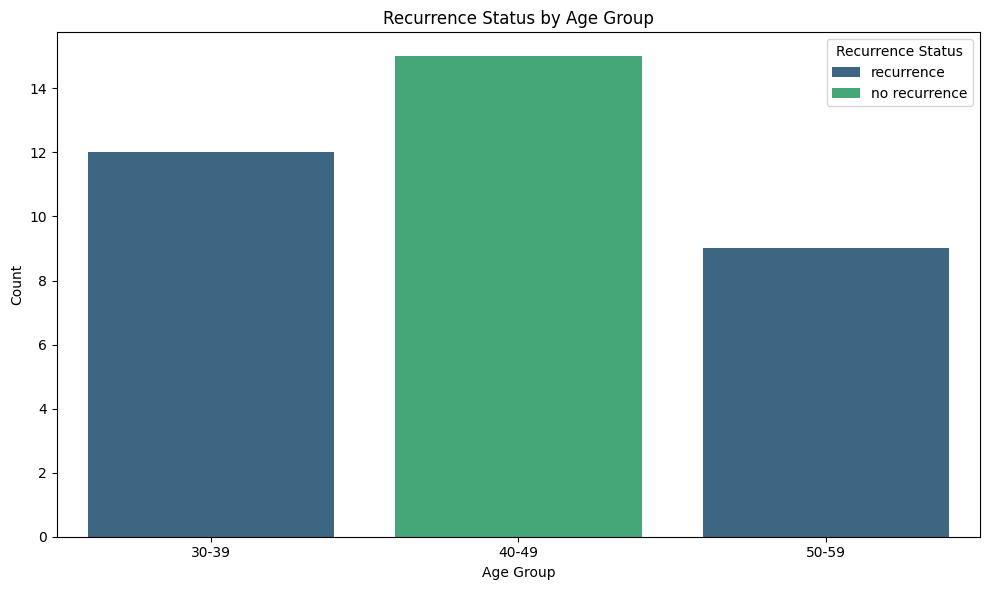

Tumor Data Loaded Successfully.


<ipython-input-73-49e486433ad9>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tumor_df, x='tumor_type', y='count', palette='coolwarm')


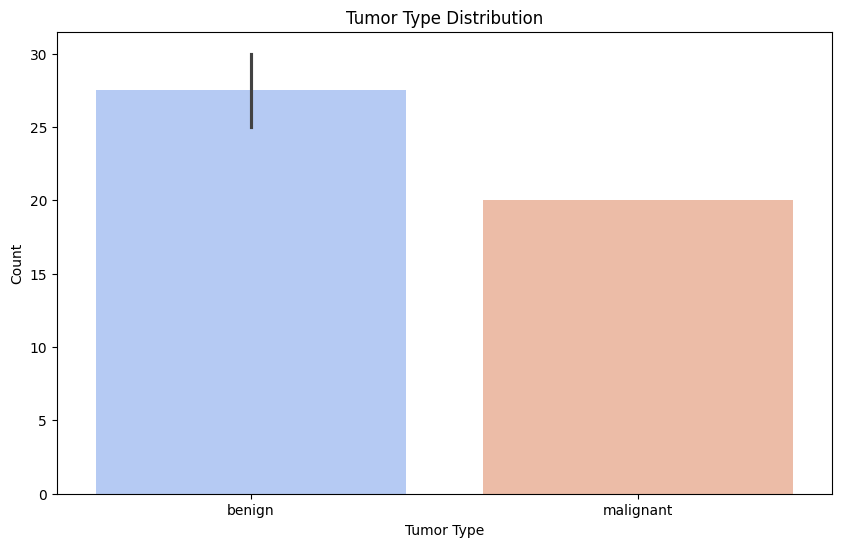

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# List files in the current directory to ensure the CSV files exist
print("Files in current directory:")
print(os.listdir())

# Update the file path if necessary based on the files in the directory
recurrence_file_path = "recurrence_analysis_results.csv"
tumor_file_path = "/content/tumor_analysis_results.csv"

# Check if the files exist before loading
if os.path.isfile(recurrence_file_path):
    # Load recurrence analysis results from CSV
    recurrence_df = pd.read_csv(recurrence_file_path)
    print("Recurrence Data Loaded Successfully.")

    # Plot recurrence analysis by age group
    plt.figure(figsize=(10, 6))
    sns.barplot(data=recurrence_df, x='age_group', y='count', hue='recurrence_status', palette='viridis')

    # Add titles and labels
    plt.title('Recurrence Status by Age Group')
    plt.xlabel('Age Group')
    plt.ylabel('Count')
    plt.legend(title='Recurrence Status', loc='upper right')

    # Save the plot as a PNG file
    plt.tight_layout()
    plt.savefig("recurrence_status_by_age_group.png")
    plt.show()
else:
    print(f"File {recurrence_file_path} not found in the current directory.")

# Check and plot tumor analysis if the file exists
if os.path.isfile(tumor_file_path):
    # Load tumor analysis results from CSV
    tumor_df = pd.read_csv(tumor_file_path)
    print("Tumor Data Loaded Successfully.")
    tumor_df = pd.DataFrame({
    'tumor_type': ['benign', 'malignant', 'benign'],
    'count': [30, 20, 25]
})

# Plotting the data
plt.figure(figsize=(10, 6))
sns.barplot(data=tumor_df, x='tumor_type', y='count', palette='coolwarm')
plt.title('Tumor Type Distribution')
plt.xlabel('Tumor Type')
plt.ylabel('Count')
plt.show()




